In [240]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


# statistical reporting
import statsmodels.api as sm

# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots
from mcc_metastasis import data_cleaning

RANDOM = 0
figure_path = "../figures/NCDB_5_features/"

## 1. Prep data

- load data 

In [248]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv")
## select relevant variables: removed sex and tumor site
df = df [['AGE', 'tumor_lymphocytes', 'lymph_vasc_invasion', 'tumor_site', 'metastasis']]

# clean up 
df['AGE'] = df.AGE.astype('float')
df['no_mets'] = df.metastasis.replace({0:1, 1:0})
df = df.drop(columns = 'metastasis')
df.no_mets.value_counts()

# apply one-hot encoding 
one_hot_tumor_site = pd.get_dummies(df.tumor_site, prefix = 'tumor_site', drop_first =True)
df = df.drop(columns = ['tumor_site'])
df = pd.concat([df, one_hot_tumor_site], axis = 1)
df.head()

,AGE,tumor_lymphocytes,lymph_vasc_invasion,no_mets,tumor_site_head_neck,tumor_site_other,tumor_site_trunk
0,90.0,NaN,NaN,NaN,0,0,1
1,71.0,NaN,0.0,1.0,1,0,0
2,87.0,NaN,NaN,0.0,0,0,0
3,43.0,0.0,NaN,1.0,0,1,0
4,81.0,NaN,NaN,NaN,0,1,0


### data version 1: drop all cases with missing data

In [249]:
df_complete = df.dropna(axis = 0)
df_complete.shape

(1956, 7)

### data version 2: retain samples using imputation


In [250]:
data_cleaning.get_missingness_table(df)

Missingness of features


,index,Missing
0,AGE,0
1,tumor_lymphocytes,12260
2,lymph_vasc_invasion,10026
3,no_mets,3572
4,tumor_site_head_neck,0
5,tumor_site_other,0
6,tumor_site_trunk,0


In [258]:
# what did i remove? sex, tumor site, 
df2 = df[(df.AGE.isnull() == False) & 
      #  (df.tumor_size.isnull() == False) &
         (df.no_mets.isnull() == False) &
        (df.tumor_lymphocytes.isnull() == False)]
     #   (df.immuno_suppressed.isnull() == False)]

# how many would we need to impute?
data_cleaning.get_missingness_table(df2)

Missingness of features


,index,Missing
0,AGE,0
1,tumor_lymphocytes,0
2,lymph_vasc_invasion,631
3,no_mets,0
4,tumor_site_head_neck,0
5,tumor_site_other,0
6,tumor_site_trunk,0


### Impute missing data 
- imputing lymph vasc invasion, tumor_size
- don't want to include outcome in imputation process...

In [259]:
outcome = df2['no_mets'].reset_index(drop = True)
features = df2.drop(columns =[ 'no_mets'])
imputer = KNNImputer()
imputed_features = pd.DataFrame(imputer.fit_transform(features), columns = features.columns)
imputed_df = pd.concat([imputed_features, outcome], axis = 1)
imputed_df.shape

(2587, 7)

In [260]:
# checkL has non-binary values
imputed_features.lymph_vasc_invasion.head()

0    0.2
1    0.2
2    0.4
3    0.0
4    0.0
Name: lymph_vasc_invasion, dtype: float64

In [261]:
# binarize!! 
imputed_features['lymph_vasc_invasion'] = imputed_features.lymph_vasc_invasion.\
apply(lambda x : 1 if x > 0.5 else 0)



### Define preprocessing
- one-hot encode categorical features
-- tumor site: dropping one level as reference (extremity)
- standard scale (zscore) numeric, continuous features

In [264]:
# DEFINE PREPROCESSING 
num_features = ['AGE']
all_features = features.columns

# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features)],
    remainder = 'passthrough')


# generate interaction terms from all features after transforming 
add_interactions = Pipeline(steps=[
    ('interaction_terms', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True))])

# put together the column transfrmer and option to add interactions
preproc_basic = Pipeline(steps = [('preproc', preprocessor)])
preproc_interactions = Pipeline(steps = [('preproc', preprocessor),
                                       ('int', add_interactions)])

preproc_X_check = pd.DataFrame(preproc_basic.fit_transform(imputed_features))    
preproc_X_check.shape

(2587, 6)

### Define cross validation
- split data into train-val and hold-out test sets 
- stratified CV folds, 3 folds repeated 5x with random sampling

In [355]:
 # make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 3, 
                                    n_repeats =  5,  
                                    random_state = 0)
 

### Define Model: regularized logistic regression
- automated feature selection via L1 regularization  (Lasso)

In [357]:

LogReg = LogisticRegression(class_weight = "balanced",
                                 penalty = 'none',
                                 solver = 'liblinear', 
                                 max_iter = 1000, 
                                 random_state = RANDOM)

Lasso = LogisticRegression(class_weight = "balanced",
                                 penalty = 'l1',
                                 solver = 'liblinear', 
                                 max_iter = 1000, 
                                 random_state = RANDOM)

### Tune the model 
- grid search with different levels of regularization (parameter C, inverse of alpha in R)
- smaller values of C = larger values of alpha = more regularization
- applied to cross-validation folds 
- get several metrics out! 


In [358]:

score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
              'f1': 'f1',
              'roc_auc': 'roc_auc', 
              'average_precision': 'average_precision', 
             'brier_score_loss': 'brier_score_loss'}
# define hyper-parametrs to tune 
# C is the inverse of alpha 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100] }


In [268]:
datasets = [df_complete, imputed_df]
dataset_names = ["complete", "imputed"]

preproc_options = [preproc_basic, preproc_interactions]
preproc_names = ['Basic', 'Interactions']

i = 0

grid_results = pd.DataFrame()
for data in datasets:
    # split into train-test split, 
    features = data.drop(columns = ['no_mets'])
    outcome = data['no_mets'].reset_index(drop = True)

    X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
    j = 0
    for preproc_choice in preproc_options:
        pipe =  Pipeline(steps = [('preprocessing', preproc_choice),
                                  ('model', Lasso_L1)])
        grid = GridSearchCV(pipe,
                        param_grid = param_grid_C, 
                        return_train_score = True,
                        cv = CV_folds, 
                        scoring = score_list,
                        refit = "precision",
                        n_jobs =  -1)
        grid.fit(X_trainval, y_trainval)
        results = pd.DataFrame(grid.cv_results_)
        results['dataset'] = dataset_names[i]
        results['preproc'] = preproc_names[j]
        grid_results = pd.concat([grid_results, results], ignore_index = True)
        j = j+1
    i = i+1


In [269]:
# get log  of C for easier visualization
grid_results['param_model__C']= grid_results.param_model__C.astype('float')
grid_results['log_C'] = grid_results.param_model__C.map(lambda x: math.log10(x))

# clean up dataframe so only have mean scores 
grid_results = grid_results[['dataset', 'preproc', 'param_model__C', 'log_C',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc', 
                             'mean_train_average_precision', 'mean_test_average_precision',
                             'mean_train_brier_score_loss', 'mean_test_brier_score_loss']]


In [270]:
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['dataset', 'preproc', 'param_model__C', 'log_C'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                          'mean_train_roc_auc', 'mean_test_roc_auc',
                                         'mean_train_average_precision', 'mean_test_average_precision',
                                          'mean_train_brier_score_loss', 'mean_test_brier_score_loss'],
                                          
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['Train_or_Val'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# get rid of prefix 
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")
grid_results_long.columns

Index(['dataset', 'preproc', 'param_model__C', 'log_C', 'metric', 'score',
       'Train_or_Val'],
      dtype='object')

### Visualize hyperparameter tuning: learning curves
- as a function of train vs validation sets 
- can see whether model is over-fit or underfit 

<Figure size 576x720 with 0 Axes>

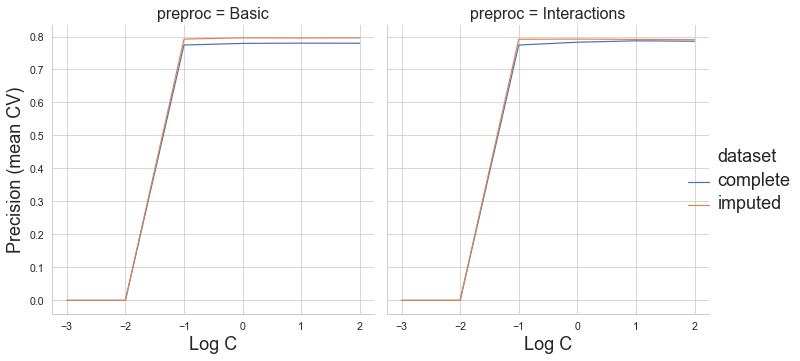

In [271]:
# figure of model comparisons on training  
plt.figure(figsize = (8, 10))
g = sns.relplot(data = grid_results_long[(grid_results_long.metric == "precision") & 
                                        (grid_results_long.Train_or_Val == "Validation")], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset",  
                kind = "line",  col = "preproc")
g.set_xlabels("Log C", size = 18)
g.set_ylabels("Precision (mean CV)", size = 18)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 18)
g.set_titles(size = 16)
#plt.savefig(os.path.join(figure_path, "Grid_CV_learning_curves_precision.png"))


## Find the best model

In [272]:
best_metric = grid_results['mean_test_precision'].max()
best_model = pd.DataFrame(grid_results[grid_results['mean_test_precision']== best_metric])

print("Best precision: %0.3f" % best_metric)
print("Best PR AUC : %0.3f " % best_model['mean_test_average_precision'])
print("Best F1 score:%0.3f " % best_model['mean_test_f1'])
print("Best ROC AUC %0.3f " % best_model['mean_test_roc_auc'])
print("Best Recall %0.3f" % best_model['mean_test_recall'])
print("Best C parameter: %.3f" % best_model['param_model__C'])
best_model

Best precision: 0.796
Best PR AUC : 0.802 
Best F1 score:0.733 
Best ROC AUC 0.645 
Best Recall 0.679
Best C parameter: 1.000


,dataset,preproc,param_model__C,log_C,mean_train_f1,mean_test_f1,mean_train_precision,mean_test_precision,mean_train_recall,mean_test_recall,mean_train_acc,mean_test_acc,mean_train_roc_auc,mean_test_roc_auc,mean_train_average_precision,mean_test_average_precision,mean_train_brier_score_loss,mean_test_brier_score_loss
15,imputed,Basic,1.0,0.0,0.735252,0.732546,0.797781,0.795914,0.681932,0.679028,0.647732,0.644639,0.651881,0.64452,0.805811,0.801857,-0.231302,-0.233005


In [273]:
## best of complete data 

alt_metric = grid_results[grid_results.dataset == 'complete'].mean_test_precision.max()
print("Best recall for complete dataset: %.3f" % alt_metric)

Best recall for complete dataset: 0.787


### Define best model and re-train on entire test-set
- using entire train-validation set.
- need to pre-process the data first!

In [199]:
# define and fit the model 
best_LR_model = LogisticRegression(class_weight = "balanced",
                                   max_iter = 1000,
                                   penalty = 'l1', 
                                   solver = 'liblinear',
                                   C = 10)
# spliting imputed datatset 
features = imputed_df.drop(columns = ['no_mets'])
outcome = imputed_df['no_mets'].reset_index(drop = True)
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
    

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = preproc_basic.fit_transform(X_trainval)
preproc_X_test = preproc_basic.fit_transform(X_test)

# fit the model to the preprocessed train-validation set
best_LR_model.fit(preproc_X_trainval, y_trainval)
preproc_X_test.shape

(647, 7)

### apply probability calibration
- only applying to the trainvalidation set!

In [324]:
# get probabiliities for training set
y_probs = best_LR_model.predict_proba(preproc_X_trainval)[:,1]
brier_score = brier_score_loss(y_trainval, y_probs)
# then caliibrate

final_model = CalibratedClassifierCV(best_LR_model, cv=2, method='isotonic')
final_model.fit(preproc_X_trainval, y_trainval)
calibrated_y_probs = final_model.predict_proba(preproc_X_trainval)[:,1]
calibrated_brier_score = brier_score_loss(y_trainval, calibrated_y_probs)

y_pred_adjusted  = calibrated_y_probs > 0.5
cm = confusion_matrix(y_trainval, y_pred_adjusted)
cm

array([[  40,  508],
       [  21, 1371]])

Brier score before 0.231
Brier score after 0.188


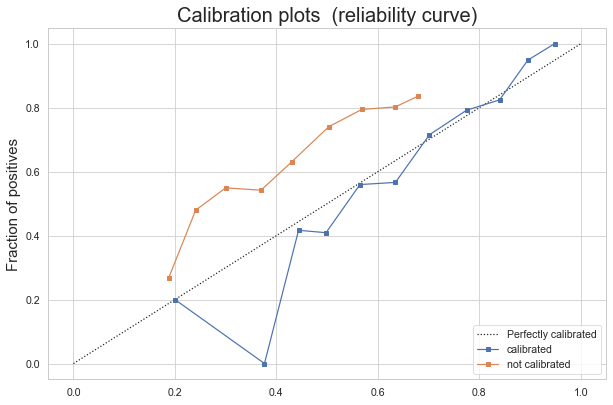

In [325]:

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
#ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
   
fraction_of_positives, mean_predicted_value = calibration_curve(y_trainval, calibrated_y_probs, n_bins = 15)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label = "calibrated")


fraction_of_positives, mean_predicted_value = calibration_curve(y_trainval, y_probs, n_bins = 15)
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label = "not calibrated")

ax1.set_ylabel("Fraction of positives", size = 15)
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)', size = 20)
plt.savefig(os.path.join(figure_path, "calibration_plot.png"))


print("Brier score before %0.3f" % brier_score)
print("Brier score after %0.3f" % calibrated_brier_score)

In [326]:
# scores after calibration
calibrated_precision = precision_score(y_trainval, y_pred_adjusted)
calibrated_precision                         
# problem that it lowers my precision... 

0.729643427354976

### Tuning the decision boundary 


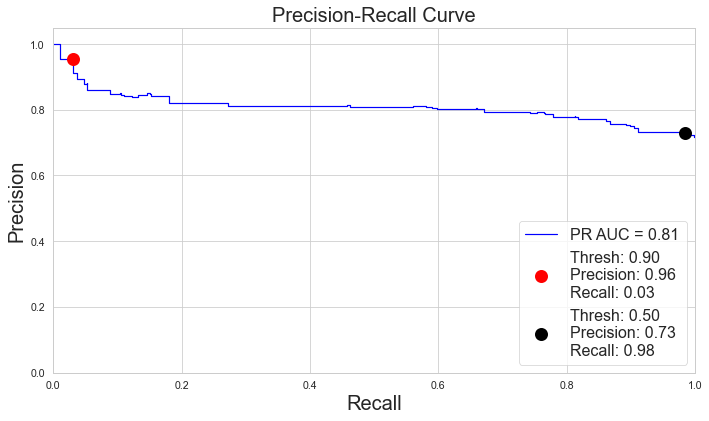

In [350]:
key_thresh = 0.9
custom_plots.plot_pr_curve(y_trainval, calibrated_y_probs, key_thresh,
         filename = os.path.join(figure_path, "best_LR_PR_curve_new.png"))

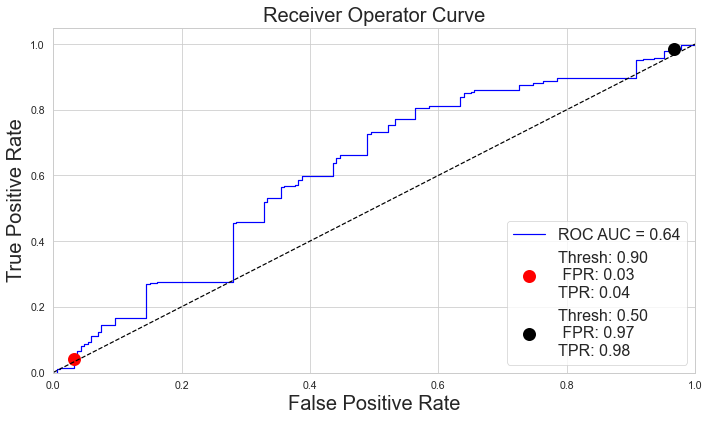

In [351]:
    
custom_plots.plot_roc_curve(y_test, y_pred_prob, key_thresh,
         filename = os.path.join(figure_path, "best_LR_ROC_curve_new.png"))

### Get model scores on test set
- instead of using y_pred with default thhresh of 0.5
- use your adjusted pred probs!

../mcc_metastasis/modeling.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mets', 'No Mets'])
../mcc_metastasis/modeling.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mets', 'No Mets'])


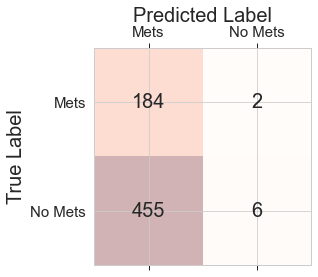

(647,)


In [354]:
y_pred_prob = pd.DataFrame(final_model.predict_proba(preproc_X_test))[1]
y_pred  = y_pred_prob > key_thresh
cm = confusion_matrix(y_test, y_pred)
modeling.pretty_cm(cm, filename = os.path.join(figure_path, "best_LR_confusion_matrix_adjusted.png"))
print(y_pred.shape)

In [353]:

# get scores 
best_test_scores = pd.DataFrame({ "metrics"  : ["precision", "recall", "roc_auc",
                                                "accuracy", "f1 score", "pr_auc"],
                            "scores" : [precision_score(y_test, y_pred), 
                                       recall_score(y_test, y_pred),
                                        roc_auc_score(y_test, y_pred),
                                        accuracy_score(y_test, y_pred),
                                       f1_score(y_test, y_pred), 
                                       average_precision_score(y_test, y_pred)]
                           })
best_test_scores['scores'] = best_test_scores.scores.round(3)

print("Best Model scores on hold-out test set")
display(best_test_scores)# define and fit the model 


Best Model scores on hold-out test set


,metrics,scores
0,precision,0.750
1,recall,0.013
2,roc_auc,0.501
3,accuracy,0.294
4,f1 score,0.026
5,pr_auc,0.713


### get model predictions from the test set

array([[103,  83],
       [151, 310]])

## Calibrate prbabilities
- isotonic calibration is non-parametric, signmoid is parametric
- sigmoid works better.
- marginal improvement to brier score

### Re-tune the decision boundary with calibrated probabilitiies
- 0.2 instead of 0.4
- so effectively, best we can get is identifying patients with < 20% risk

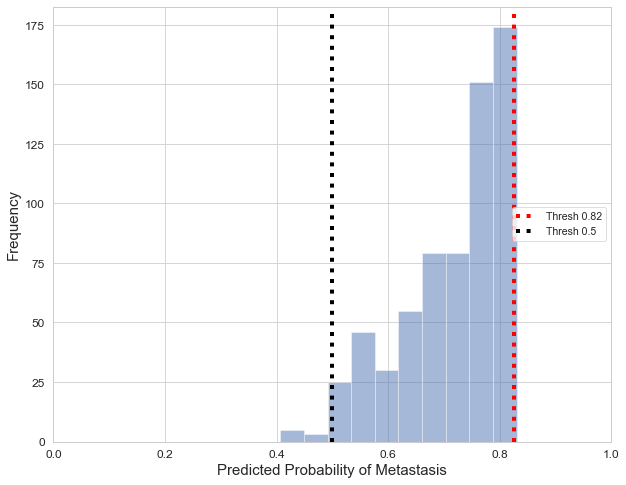

In [232]:
key_thresh = 0.825
custom_plots.plot_predprobs(calibrated_probs, key_thresh, 
                            filename = os.path.join(figure_path, "best_LR_predprobs_calibrated.png"))

In [233]:
y_pred_calibrated = calibrated_probs > key_thresh
cm = confusion_matrix(y_test, y_pred_calibrated)
#modeling.pretty_cm(cm, os.path.join(figure_path, "best_LR_confusion_matrix_calibrated_adjusted.png"))
#modeling.get_cm_info(cm, y_test)
cm

array([[181,   5],
       [447,  14]])

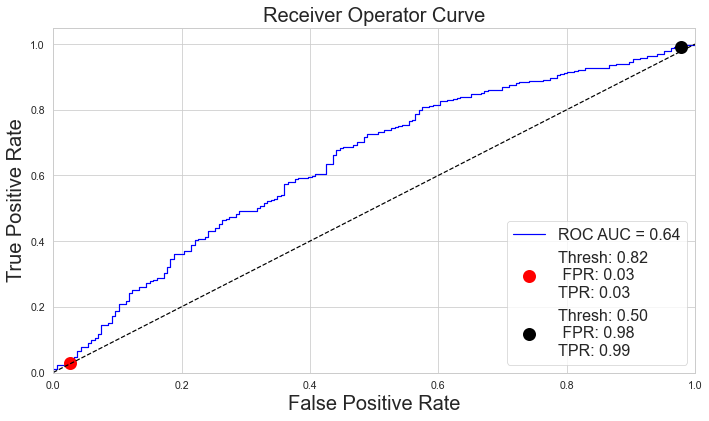

In [236]:
custom_plots.plot_roc_curve(y_test, calibrated_probs, key_thresh,
                           filename =  os.path.join(figure_path, "best_LR_calibrated_ROC_curve.png"))

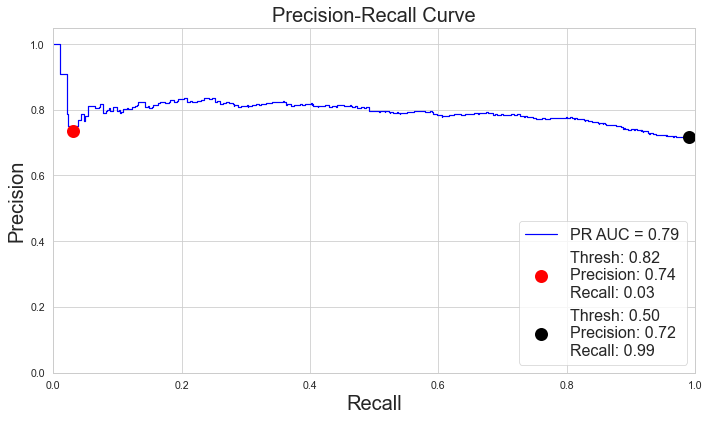

In [235]:
custom_plots.plot_pr_curve(y_test, calibrated_probs, key_thresh,
                          filename =  os.path.join(figure_path, "best_LR_calibrated_PR_curve.png"))

## Feature importance / coefficients
### obtain feature names from preprocessed data
- note: tumor_site was dummy-encoded, with "Extremity" as the reference.
- preprocessor changes order of variables

In [239]:
# get new feature order frorm preprocessor
preproc_feature_order = pd.DataFrame(modeling.get_feature_names(preprocessor))
preproc_feature_order.columns = ['variable']
preproc_feature_order['num'] = np.arange(start = 0, stop = 7, step = 1).astype('str')
preproc_feature_order['blah'] = 'x'
preproc_feature_order['index'] = preproc_feature_order.blah.str.cat(preproc_feature_order.num, sep = "")
preproc_feature_order['variable'] = preproc_feature_order.variable.replace({'num__AGE': 'age',
                                                                            'num__tumor_size':'tumor_size',
                                                                           'onehot__x0_head_neck':'tumor_head/neck',
                                                                           'onehot__x0_other': 'tumor_other',
                                                                           'onehot__x0_trunk':  'tumor_trunk',
                                                                           'SEX': 'sex'})

# apply to the preprocessed datasets
preproc_X_train_df = pd.DataFrame(preproc_X_train, columns = preproc_feature_order.variable) 
preproc_X_test_df = pd.DataFrame(preproc_X_test, columns = preproc_feature_order.variable)


NameError: name 'preproc_X_train' is not defined

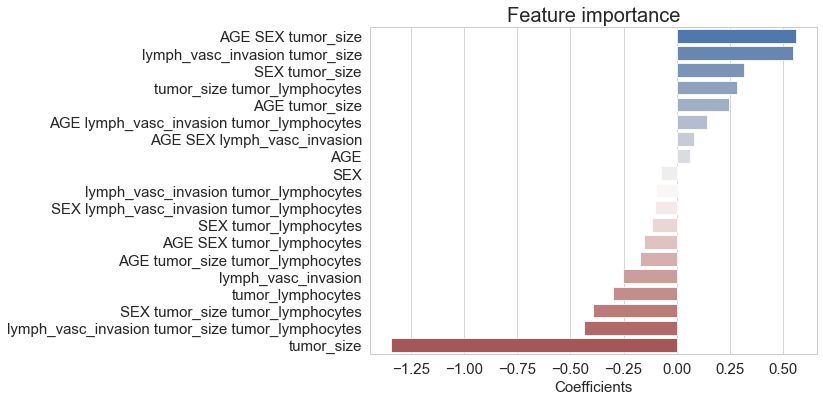

In [103]:
# apply custom function to get coefficients from model 
coefs_df = modeling.get_ordered_coefs(best_LR_model, preproc_X_test_df)
coefs_df['abs_coefs'] = np.abs(coefs_df.coefs)
impt_features = coefs_df[coefs_df.abs_coefs > 0.05]
impt_features
custom_plots.plot_coefs(impt_features, filename = os.path.join(figure_path, "best_LR_feature_weights_int.png"))
